# NER Document Classification

This notebook demonstrates two approaches to NER-based document classification:
1. BERT-based approach
2. T5-based advanced approach with attention visualization

Both approaches use the CONLL2003 dataset and Mistral API for document-level labeling.

In [1]:
import os
import torch
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import random_split

# Import BERT-related modules
from ner_doc_classification.data_processing.dataset import CONLLDataset
from ner_doc_classification.models.bert_ner import BertNERModel
from ner_doc_classification.training.train import train_ner_doc_model
from ner_doc_classification.visualization.visualization import plot_learning_curves

# Import T5-related modules
from ner_doc_classification.models.t5_advanced_ner import AdvancedT5NER
from ner_doc_classification.training.train_t5 import train_advanced_t5
from ner_doc_classification.data_processing.data_utils import load_or_create_doc_labels

/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

Set up the configuration parameters for both models.

In [2]:
# Common Configuration
PERSONAL_MISTRAL_API_KEY = os.environ.get("PERSONAL_MISTRAL_API_KEY")
if not PERSONAL_MISTRAL_API_KEY:
    raise ValueError("Please set the PERSONAL_MISTRAL_API_KEY environment variable")

NUM_NER_LABELS = 9  # PERSON, ORGANIZATION, LOCATION, DATE, TIME, MONEY, PERCENT, OTHER
NUM_DOC_LABELS = 5  # 0: World, 1: Sport, 2: Business, 3: Technology, 4: Other
DATASET_SIZE = 1000
RANDOM_SEED = 19

# BERT Configuration
BERT_MODEL_NAME = "bert-base-uncased"

# T5 Configuration
T5_MODEL_NAME = "t5-base"
T5_MODEL_CONFIG = {"dropout_rates": {"attention": 0.1, "hidden": 0.2, "output": 0.1}}

# Train T5 model with different dataset sizes
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set device to 'mps' if available, else 'cuda' if available, else 'cpu'
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

## Data Preparation

Define functions to prepare the dataset for both models.

In [3]:
def prepare_data(size: int, model_name: str, doc_label_file="data/doc_labels.csv"):
    """Prepare the dataset for training.
    
    Args:
        size (int): Number of samples to use
        model_name (str): Name of the model to use (for tokenization)
        
    Returns:
        tuple: (train_dataset, val_dataset)
    """
    # Load CONLL2003 dataset
    dataset = load_dataset("conll2003")
    random_indices = np.random.choice(
        len(dataset["train"]), size=size, replace=False
    ).tolist()

    dataset["train"] = dataset["train"].select(random_indices)
    tokens = dataset["train"]["tokens"]
    ner_tags = dataset["train"]["ner_tags"]
    doc_labels = load_or_create_doc_labels(tokens=tokens, api_key=PERSONAL_MISTRAL_API_KEY, file_name=doc_label_file)

    conll_dataset = CONLLDataset(tokens, ner_tags, doc_labels)

    # Split data
    size = len(conll_dataset)
    train_size = int(0.8 * size)
    val_size = size - train_size
    train_dataset, val_dataset = random_split(conll_dataset, [train_size, val_size])

    return train_dataset, val_dataset

## BERT-based Approach

Train and evaluate the BERT-based model with loss visualization.


Training BERT model with dataset size: 1000
Loaded labels from cache file: ../data/doc_labels.csv

Training on mps


Epochs:  33%|███▎      | 1/3 [00:34<01:08, 34.49s/it]


Epoch 1/3
Average Training Loss: 2.2072
Average Validation Loss: 1.9673


Epochs:  67%|██████▋   | 2/3 [01:08<00:34, 34.18s/it]


Epoch 2/3
Average Training Loss: 1.9111
Average Validation Loss: 1.8944


Epochs: 100%|██████████| 3/3 [01:42<00:00, 34.12s/it]
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa


Epoch 3/3
Average Training Loss: 1.7537
Average Validation Loss: 1.8580

NER Classification Report for size 1000:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7173
           1       0.52      0.30      0.38       273
           2       0.70      0.32      0.43       168
           3       0.54      0.36      0.44       255
           4       0.30      0.22      0.25       120
           5       0.61      0.14      0.23       264
           6       0.50      0.11      0.18        45
           7       0.61      0.07      0.12       159
           8       0.67      0.02      0.04        87

    accuracy                           0.86      8544
   macro avg       0.59      0.28      0.34      8544
weighted avg       0.83      0.86      0.83      8544


DOC Classification Report for size 1000:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.38      

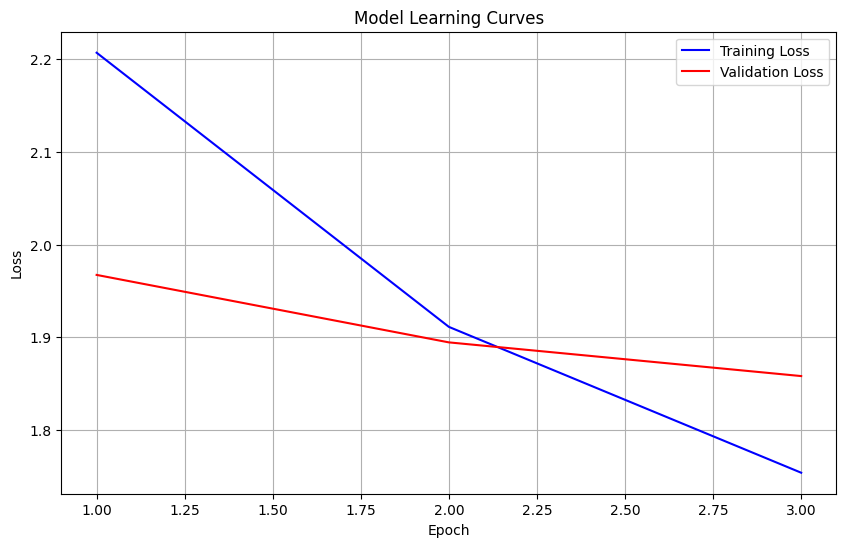

In [4]:
def train_bert_model(size: int, save_dir: str = "outputs"):
    """Train BERT model with specified dataset size."""
    print(f"\nTraining BERT model with dataset size: {size}")
    os.makedirs(save_dir, exist_ok=True)
    
    # Prepare data
    train_dataset, val_dataset = prepare_data(size, BERT_MODEL_NAME, "../data/doc_labels.csv")

    # Initialize model
    model = BertNERModel(n_ner_tags=NUM_NER_LABELS, n_doc_labels=NUM_DOC_LABELS, model_name=BERT_MODEL_NAME)

    # Train model
    train_losses, val_losses, report = train_ner_doc_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        device=device,
        num_epochs=3
    )
    
    print(f"\nNER Classification Report for size {DATASET_SIZE}:")
    print(report[0])

    print(f"\nDOC Classification Report for size {DATASET_SIZE}:")
    print(report[1])


    plot_learning_curves(
        train_losses,
        val_losses,
        save_path=f"{save_dir}/bert_learning_curves_{size}.png"
    )

# Train BERT model with small dataset of DATASET_SIZE
train_bert_model(DATASET_SIZE)

## T5-based Advanced Approach

Train and evaluate the T5-based model with loss visualization.


Training T5 model with dataset size: 1000
Loaded labels from cache file: ../data/doc_labels.csv

Training on mps


Epochs: 100%|██████████| 3/3 [01:56<00:00, 38.97s/it]
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pdeb/miniforge3/envs/ner/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa


NER Classification Report for size 1000:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6693
           1       0.00      0.00      0.00       273
           2       0.00      0.00      0.00       180
           3       0.00      0.00      0.00       252
           4       0.00      0.00      0.00       135
           5       0.00      0.00      0.00       267
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00       141
           8       0.00      0.00      0.00        54

    accuracy                           0.84      8010
   macro avg       0.09      0.11      0.10      8010
weighted avg       0.70      0.84      0.76      8010


DOC Classification Report for size 1000:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.35      0.60      0.44       210
           2       0.10      0.01      0.02     

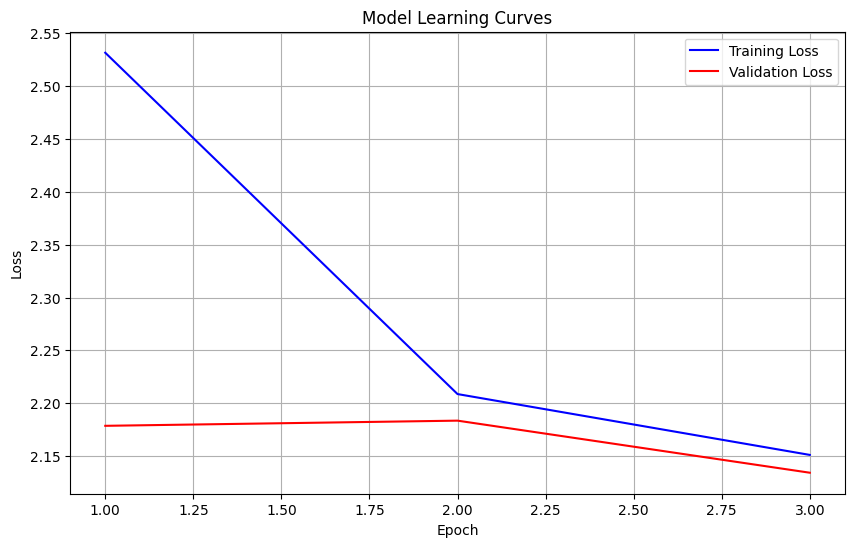

In [5]:
def train_t5_model(size: int, save_dir: str = "outputs"):
    """Train T5 model with specified dataset size and create visualizations."""
    print(f"\nTraining T5 model with dataset size: {size}")
    os.makedirs(save_dir, exist_ok=True)

    # Prepare data
    train_dataset, val_dataset = prepare_data(size, T5_MODEL_NAME, "../data/doc_labels.csv")

    # Initialize model
    model = AdvancedT5NER(
        n_ner_tags=NUM_NER_LABELS, 
        n_doc_labels=NUM_DOC_LABELS,
        model_name=T5_MODEL_NAME,
        dropout_rates=T5_MODEL_CONFIG["dropout_rates"]
    )

    # # Print model parameters
    # print("\nModel Parameters:")
    # param_counts = model.count_parameters()
    # for component, count in param_counts.items():
    #     print(f"{component}: {count:,}")

    # Train model with attention collection
    train_losses, val_losses, report, attention_maps = train_advanced_t5(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        collect_attention_maps=True,
        device=device,
        num_epochs=3
    )
    print(f"\nNER Classification Report for size {DATASET_SIZE}:")
    print(report[0])

    print(f"\nDOC Classification Report for size {DATASET_SIZE}:")
    print(report[1])
    
    # Create visualizations
    print("\nGenerating visualizations...")
    # Learning curves
    plot_learning_curves(
        train_losses,
        val_losses,
        save_path=f"{save_dir}/t5_learning_curves_{size}.png"
    )

train_t5_model(DATASET_SIZE)
